In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [4]:
%matplotlib widget

# Load experimental subjects

In [5]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,100um offset stim electrode
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,"100um offset stim electrode, probeB LFP estim ..."
2,GAT1-KO,672785,EEGNPXspont_estim_2023-07-05_12-39-59,none,0,awake,all,25,True,False,2.0,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...,EEG has low amplitude signals and all chs look...
3,GAT1-KO,672789,EEGNPXspont_estim_2023-07-13_13-28-01,none,0,awake,none,25,True,True,2.0,"stainless steel skull screw, right CB","stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...,NaN
4,wildtype,654181,estim_vis_2022-11-22_09-42-58,isoflurane,0,"awake,isoflurane","7,8,11,13",25,True,True,NaN,NaN,NaN,NaN,F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,good control mouse with RT units


# Test one session

In [6]:
choose_sub = 3
exprow = all_subexp.iloc[choose_sub]
exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [7]:
if exprow.NPX_analysis:
    print('Yes, this experiment has good NPX data.')
else:
    print('This experiment does NOT have good NPX data, skip it.')

Yes, this experiment has good NPX data.


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


In [9]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
    print(stim_elec_data)
else:
    print('Stim electrode location file not found.')

{'surface': {'area': 'MOp1', 'ccf_coords': [140, 71, 137]}, 'tip': {'area': 'MOp6a', 'ccf_coords': [162, 115, 154]}}


In [10]:
stim_elec_data['tip']['area']

'MOp6a'

## Load experimental data

### Load stim log

In [11]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [12]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial
0,biphasic,50,1803.26003,1803.26043,0.0004,0,True,0.000000,True
1,biphasic,50,1814.41505,1814.41545,0.0004,0,True,5.664531,False
2,biphasic,50,1823.44439,1823.44479,0.0004,0,True,4.426838,False
3,biphasic,50,1835.93751,1835.93791,0.0004,0,True,0.000000,True
4,biphasic,50,1846.20058,1846.20098,0.0004,0,True,6.203648,False


### Load manual annotation of event in SWD

In [13]:
stimSWDfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP.npy')
stimSWDboolfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF.npy')
# stimSWDbool2file = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF2.npy')
if os.path.exists(stimSWDfile):
    stim_in_SWD = np.load(stimSWDfile)
    stim_in_SWDtf = np.load(stimSWDboolfile).astype(bool)
    # stim_in_SWDtf2 = np.load(stimSWDbool2file).astype(bool)
    print(stim_in_SWD[:10])
    # stim_log['manualSWD'] = stim_in_SWD
else:
    print('Session has no EP_in_SWD file.')

['f' 'f' 't' 't' 'f' 'f' 't' 'f' 'f' 'f']


In [14]:
print(stim_in_SWD[:20])
print(stim_in_SWDtf[:20])
# print(stim_in_SWDtf2[:20])

['f' 'f' 't' 't' 'f' 'f' 't' 'f' 'f' 'f' 'f' 't' 'f' 't' 'f' 'f' 'f' 'f'
 'f' 'f']
[ True False  True  True False False  True  True  True  True  True  True
  True  True  True False False  True  True False]


In [15]:
print(np.sum(stim_in_SWDtf))
# print(np.sum(stim_in_SWDtf2))

117


### Load SWD events

In [16]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is.')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Session has no SWD file.')
    autoSWD_df = None

Whoope there it is.


In [17]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,79.612853,80.623250,1.010396,7,"[79.61285347835067, 79.76965287072434, 79.9276..."
1,86.742826,87.446023,0.703197,6,"[86.74282584840337, 86.92642513692255, 87.0908..."
2,88.460819,90.632411,2.171592,12,"[88.46081919086488, 88.62561855223721, 88.9544..."
3,102.490765,103.025563,0.534798,3,"[102.49076482225891, 102.83996346905028, 103.0..."
4,105.004355,106.345150,1.340795,7,"[105.00435508163683, 105.35155373617852, 105.5..."


### Load pupil radius

### Load running speed

### Load EEG to use the timestamps

### Load isoflurane signal

## Load LFP

### Get probe list

In [18]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeD', 'probeF']


In [19]:
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

probeB
['AMd' 'AMv' 'AV' 'CA1' 'CA2' 'CA3' 'LD' 'SSp-ll6a' 'SSp-ll6b' 'SSp-tr1'
 'SSp-tr2/3' 'SSp-tr4' 'SSp-tr5' 'SSp-tr6a' 'TH' 'VAL' 'alv' 'ccb' 'cing'
 'null' 'root']

probeC
['CA1' 'CA3' 'DG-mo' 'DG-po' 'DG-sg' 'LGd-co' 'LGd-sh' 'MGd' 'MGm' 'MGv'
 'TH' 'VISp1' 'VISp2/3' 'VISp4' 'VISp5' 'VISp6a' 'VISp6b' 'ZI' 'alv' 'bsc'
 'fiber tracts' 'fp' 'null' 'or']

probeD
['CP' 'RT' 'SSp-bfd1' 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a'
 'SSp-bfd6b' 'VAL' 'VL' 'VPL' 'ccb' 'em' 'fi' 'fiber tracts' 'null' 'or'
 'st']

probeF
['BST' 'CP' 'MOp1' 'MOp2/3' 'MOp5' 'MOp6a' 'MOp6b' 'STR' 'ccb' 'null'
 'scwm']



### Choose probe to plot

In [20]:
probe_name = 'probeF'

## Load LFP as memmap ##
# lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
# lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
#     (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])

In [21]:
print(surface_ch)

366


In [22]:
area_choice = 'MOp' # 'SSp'
area_mask = np.array([area_choice in x for x in probe_areas])

#### Load a single channel

In [23]:
## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

In [24]:
lfp_raw_chs = lfp_data_mm[:, area_mask] # * exp.ephys_params[probe_name]['bit_volts']
print(lfp_raw_chs.shape)

(16506951, 126)


Get event traces

In [25]:
event_window = [-2.0, 2.0]
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
event_LFPchs, event_ts = get_evoked_traces(
    lfp_raw_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[probe_name]['lfp_sample_rate']
)
print(event_LFPchs.shape)

(10000, 126, 200)


In [26]:
check_window = [-0.05, 0.5]
checkinds = np.squeeze(np.argwhere((event_ts >= check_window[0]) & (event_ts <= check_window[1])))

num_samples = []
for chi, max_val in enumerate(np.max(np.max(event_LFPchs[checkinds,:,:], axis=2), axis=0)):
    num_samples.append(np.sum(event_LFPchs[checkinds,chi,:] > (max_val - 500), axis=0))
num_samples_all_trials = np.array(num_samples)

sample_thresh = 20
good_trials = np.where(np.median(num_samples_all_trials, axis=0) < sample_thresh)[0]
bad_trials = np.where(np.median(num_samples_all_trials, axis=0) >= sample_thresh)[0]

Text(0.5, 1.0, 'Good stim trials, ch 25 (200 trials)')

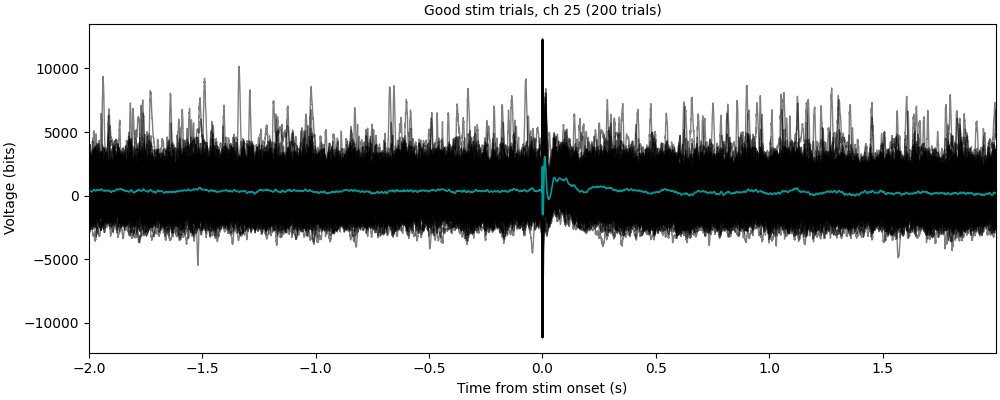

In [27]:
plot_ch = 25
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, event_LFPchs[:, plot_ch, good_trials], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(event_LFPchs[:, plot_ch, good_trials], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (bits)')
ax.set_title('Good stim trials, ch {:d} ({:d} trials)'.format(plot_ch, len(good_trials)))

Text(0.5, 1.0, 'Bad stim trials, ch 25 (4 trials)')

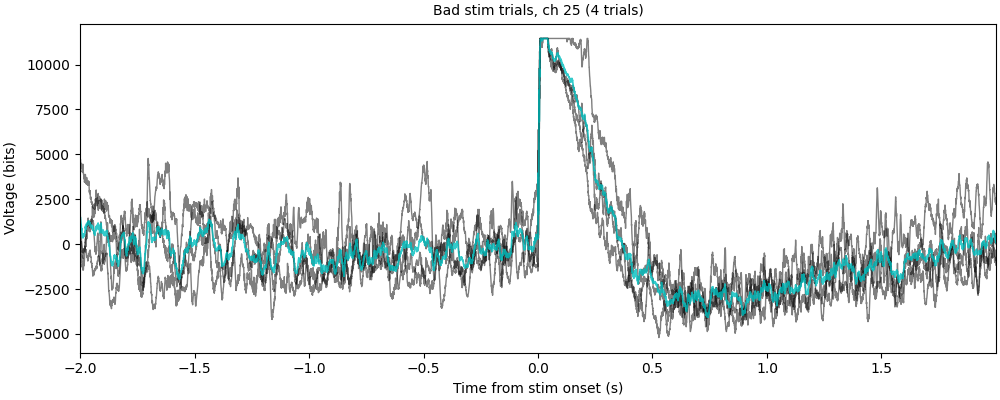

In [27]:
# plot_ch = 6
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, event_LFPchs[:, plot_ch, bad_trials], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(event_LFPchs[:, plot_ch, bad_trials], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (bits)')
ax.set_title('Bad stim trials, ch {:d} ({:d} trials)'.format(plot_ch, len(bad_trials)))

### Choose one ch and attempt to rank amplitude

In [28]:
lfp_chs = lfp_raw_chs * exp.ephys_params[probe_name]['bit_volts']
## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
hardware_filter = signal.butter(1, Wn=[0.5, 50], btype='band', fs=exp.ephys_params[probe_name]['lfp_sample_rate'])
lfp_chs = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_chs)))

In [29]:
event_window = [-2.0, 2.0]
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
event_LFPchs, event_ts = get_evoked_traces(
    lfp_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[probe_name]['lfp_sample_rate']
)
print(event_LFPchs.shape)

(10000, 126, 200)


Text(0.5, 1.0, 'Good stim trials, ch 42 (200 trials)')

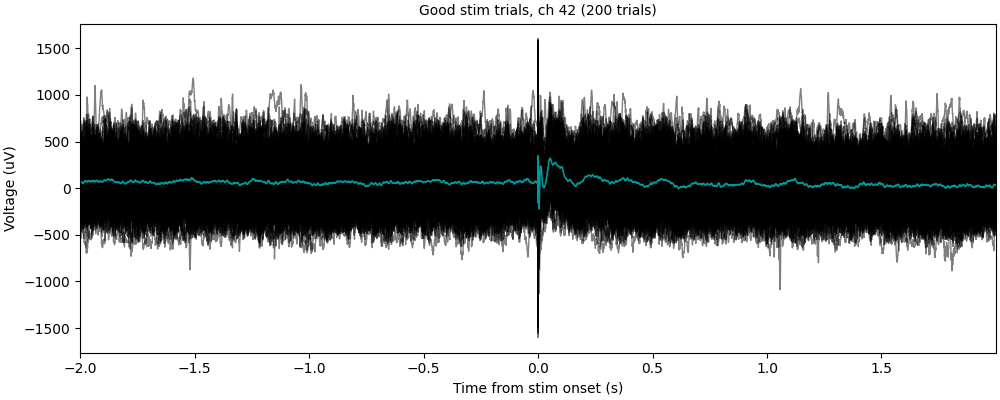

In [30]:
plot_ch = 42
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, event_LFPchs[:, plot_ch, good_trials], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(event_LFPchs[:, plot_ch, good_trials], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Good stim trials, ch {:d} ({:d} trials)'.format(plot_ch, len(good_trials)))

Get the mean amplitude in a baseline window and the response window

In [31]:
BaselineWindow = [-0.5, -0.01]
ResponseWindow = [0.005, 0.1]

In [32]:
baselineinds = np.squeeze(np.argwhere((event_ts >= BaselineWindow[0]) & (event_ts <= BaselineWindow[1])))
responseinds = np.squeeze(np.argwhere((event_ts >= ResponseWindow[0]) & (event_ts <= ResponseWindow[1])))

Pw_Baseline = np.mean(np.abs(event_LFPchs[baselineinds, :, :]), axis=0)
Pw_Response = np.mean(np.abs(event_LFPchs[responseinds, :, :]), axis=0)
print(Pw_Response.shape)

(126, 200)


### Get the mean rank value for all SWD EPs

All trials

In [33]:
plot_ch = 26
ch_ranked = np.argsort(Pw_Response[plot_ch, :])
print(ch_ranked)
print(len(ch_ranked))

[163 146   5  92  73 104 137 156  88 176 154 147 190  80 132 105 112  74
 192  42 114 153 161  87 152  10 191   9  31  82 133 195 197 198  25 113
 188 148 160 126  90  66  27  30 107  11  68  44 196  77 177 141  96 162
  89  71  20  94  15 135 121 168 127  86 134  58  45  13 130 179 116  39
  22 102  48  65 117  37  76  43 150  63  69  62   2  26 142 140  52  59
  14 149  21 138   7   4 165  56  53 101 123  50  29 119  67 180  17 155
  18  23 115 173  49   6 164  83   3  38  70 169  79 124 194 166  47 120
 157 111 118  24 167 151  36 131   1 108  78  84  95  40 193 159 189  75
 145 129 175  12 181 110 174 158  97  99  60  16 185   8 183  41 170 172
 178  81 139 187 144 143 125  33 199  85  35  61   0 182  55 184  51  54
  32 109  28 122  64 106 136 186 171 100  19  98  57  93 128  46 103  72
  91  34]
200


In [34]:
trial_ranks = np.empty_like(ch_ranked)
trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
rankings = trial_ranks / np.max(trial_ranks)
print(rankings)

[0.875 0.675 0.425 0.585 0.48  0.015 0.57  0.475 0.79  0.14  0.13  0.23
 0.74  0.34  0.455 0.295 0.78  0.535 0.545 0.955 0.285 0.465 0.365 0.55
 0.65  0.175 0.43  0.215 0.915 0.515 0.22  0.145 0.905 0.85  1.    0.865
 0.665 0.39  0.59  0.36  0.7   0.8   0.1   0.4   0.24  0.335 0.98  0.625
 0.375 0.565 0.51  0.895 0.445 0.495 0.9   0.885 0.49  0.965 0.33  0.45
 0.775 0.87  0.42  0.41  0.925 0.38  0.21  0.525 0.235 0.415 0.595 0.28
 0.99  0.025 0.09  0.72  0.395 0.25  0.685 0.605 0.07  0.82  0.15  0.58
 0.69  0.86  0.32  0.12  0.045 0.275 0.205 0.995 0.02  0.97  0.29  0.695
 0.265 0.765 0.96  0.77  0.95  0.5   0.37  0.985 0.03  0.08  0.93  0.225
 0.68  0.91  0.75  0.64  0.085 0.18  0.105 0.555 0.355 0.385 0.645 0.52
 0.63  0.305 0.92  0.505 0.61  0.845 0.2   0.315 0.975 0.73  0.345 0.67
 0.075 0.155 0.325 0.3   0.935 0.035 0.47  0.825 0.44  0.26  0.435 0.84
 0.835 0.725 0.01  0.06  0.19  0.46  0.405 0.66  0.125 0.11  0.055 0.54
 0.04  0.635 0.76  0.71  0.195 0.115 0.27  0.005 0.575 0.485

In [35]:
SWDmeanrank = np.mean(rankings[stim_in_SWDtf])

Compare to randomly shuffled trials

In [36]:
ruff = np.arange(len(ch_ranked)) + 1
ruff_rankings = ruff / np.max(ruff)
rand_mean_rank = []
for i in range (100):
    np.random.shuffle(ruff_rankings)
    rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf]))
rand_mean_rank = np.array(rand_mean_rank)

Text(0.5, 1.0, 'All trials')

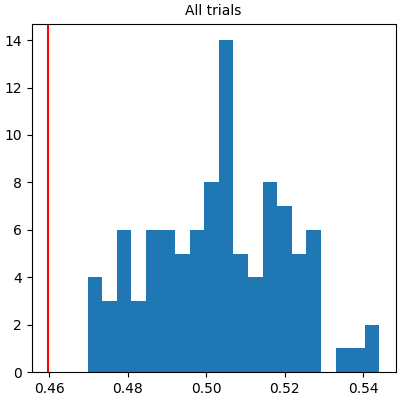

In [37]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.hist(rand_mean_rank, bins=20)
ax.axvline(SWDmeanrank, color='r')
ax.set_title('All trials')

Only non-artifact trials

In [38]:
plot_ch = 26
ch_ranked_good_trials = np.argsort(Pw_Response[plot_ch, good_trials])
print(len(ch_ranked_good_trials))
trial_ranks_good = np.empty_like(ch_ranked_good_trials)
trial_ranks_good[ch_ranked_good_trials] = np.arange(len(ch_ranked_good_trials)) + 1
rankings_good = trial_ranks_good / np.max(trial_ranks_good)
SWDmeanrank_good = np.mean(rankings_good[stim_in_SWDtf[good_trials]])

60


In [39]:
print(len(rankings_good))

60


In [40]:
ruff = np.arange(len(ch_ranked_good_trials)) + 1
ruff_rankings = ruff / np.max(ruff)
rand_mean_rank = []
for i in range (100):
    np.random.shuffle(ruff_rankings)
    rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf[good_trials]]))
rand_mean_rank = np.array(rand_mean_rank)

Text(0.5, 1.0, 'Good trials')

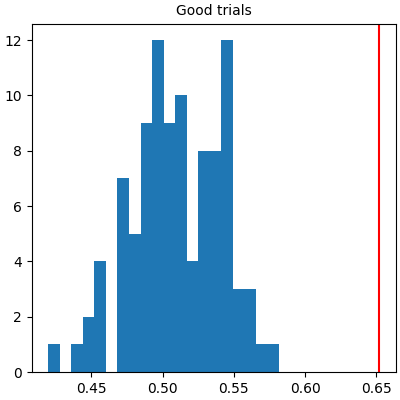

In [41]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.hist(rand_mean_rank, bins=20)
ax.axvline(SWDmeanrank_good, color='r')
ax.set_title('Good trials')

Plot the ranked trials

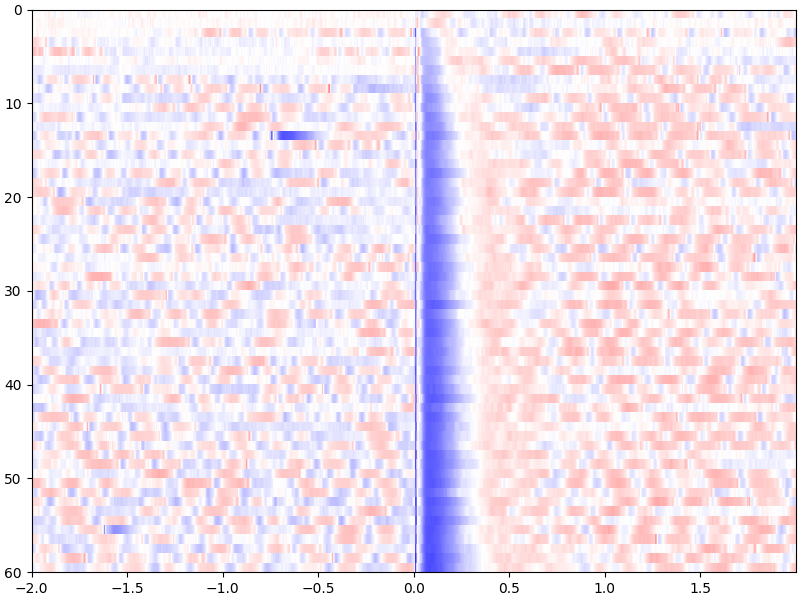

In [38]:
## Good trials ##
plot_ch = 26
vlevel = 2500
ch_ranked = np.argsort(Pw_Response[plot_ch, good_trials])
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
ax.imshow(
    event_LFPchs[:, plot_ch, :][:, good_trials[ch_ranked]].T, aspect='auto', interpolation='none',
    cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(good_trials), 0],
)

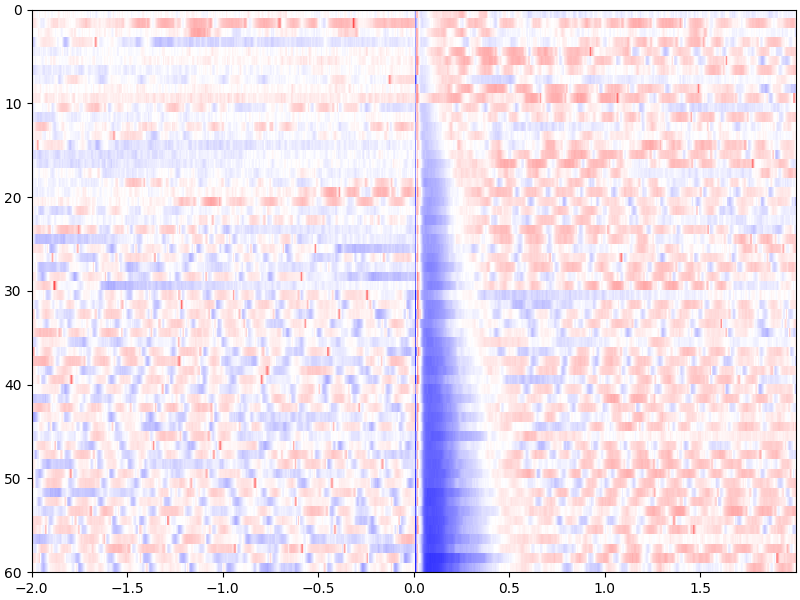

In [43]:
## All trials ##
plot_ch = 26
vlevel = 2500
ch_ranked = np.argsort(Pw_Response[plot_ch, :])
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
ax.imshow(
    event_LFPchs[:, plot_ch, ch_ranked].T, aspect='auto', interpolation='none',
    cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
)

In [42]:
print(np.sum(stim_in_SWD[good_trials[ch_ranked]][:24] == 't'))
print(np.sum(stim_in_SWD[good_trials[ch_ranked]][24:] == 't'))

14
10


# Work on looping through all subs to plot all trials

## Loop through all subjects

In [5]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})

In [6]:
sub_LFP_chs = {
    '645606': 'probeF', # SSp probeB, MOp probeF
    '644565': 'probeF', # SSp probeB, MOp probeF
    '672785': 'probeF', # SSp probeD, MOp probeF
    '672789': 'probeF', # SSp probeB, MOp probeF
}

plot_area = 'MOp' # tried SSp first like SR
event_window = [-2.0, 2.0]
check_artifact_trials = True
artifact_check_window = [-0.05, 0.5]
artifact_thresh = 20
BaselineWindow = [-0.5, -0.01]
ResponseWindow = [0.005, 0.1]

645606: EEGNPXspont_estim_2022-12-20_12-26-39
Experiment type: electrical stimulation

644565: EEGNPXspont_estim_2022-12-22_10-36-08
Experiment type: electrical stimulation

672785: EEGNPXspont_estim_2023-07-05_12-39-59
Experiment type: electrical and sensory stimulation

672789: EEGNPXspont_estim_2023-07-13_13-28-01
Experiment type: electrical and sensory stimulation



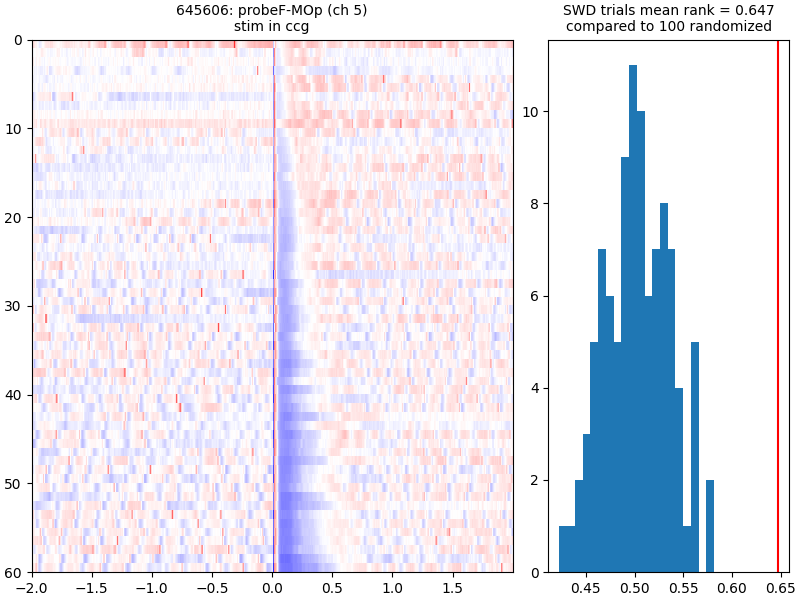

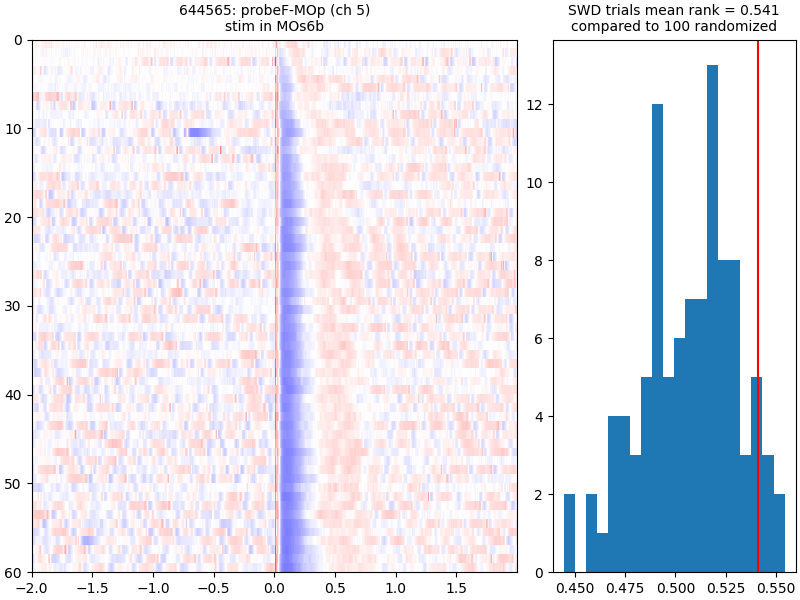

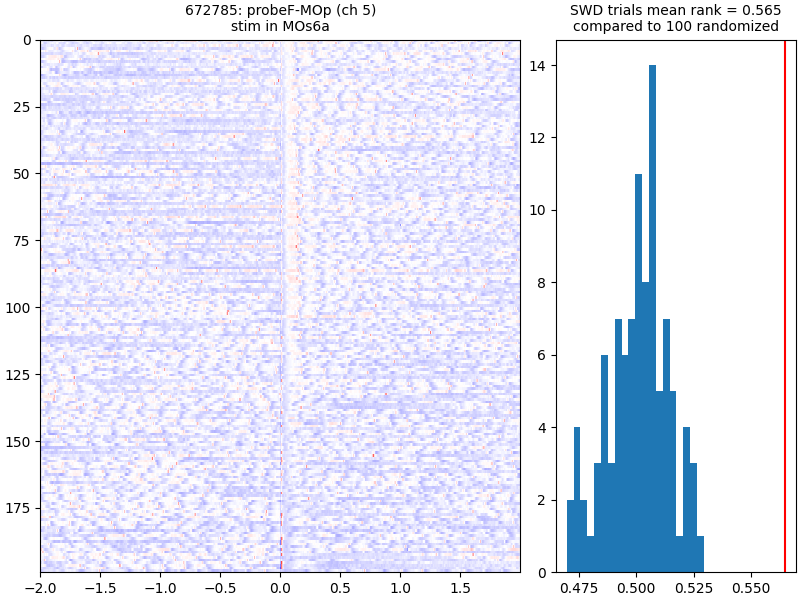

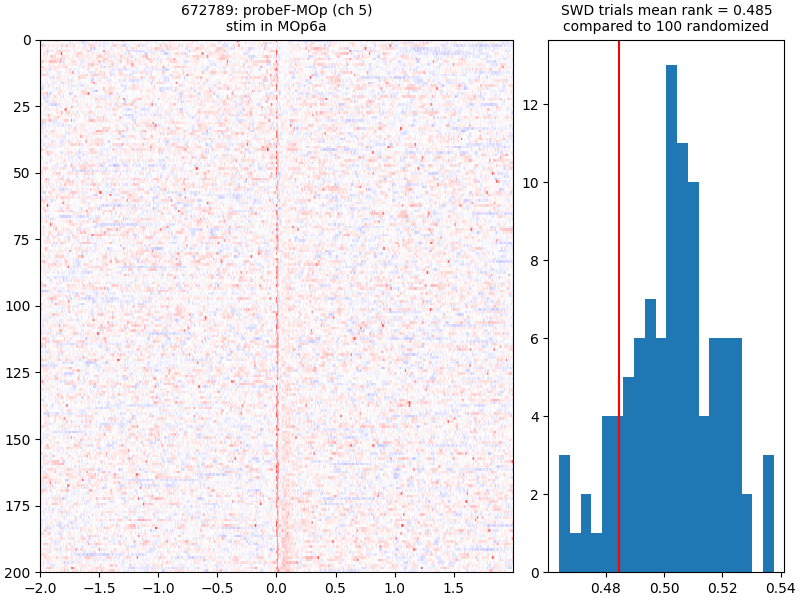

In [8]:
for rowi, exprow in all_subexp[:4].iterrows():
    print('{}: {}'.format(exprow.mouse, exprow.experiment))
    exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)
    plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
    else:
        print('Stim electrode location file not found.')
    stimSWDboolfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF.npy')
    if os.path.exists(stimSWDboolfile):
        stim_in_SWDtf = np.load(stimSWDboolfile).astype(bool)
        # print(stim_in_SWD[:10])
        # stim_log['manualSWD'] = stim_in_SWD
    else:
        print('Session has no EP_in_SWD file.')

    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    # probe_name = sub_LFP_chs[exprow.mouse]
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[sub_LFP_chs[exprow.mouse]]['probe_info']) as data_file:
        data = json.load(data_file)
    # npx_allch = np.array(data['channel'])
    # surface_ch = int(data['surface_channel'])
    # allch_z = np.array(data['vertical_pos'])
    ref_mask = np.array(data['mask'])
    # npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    # probe_ch_depths = allch_z[surface_ch] - allch_z
    probe_areas = np.array(data['area_ch'])
    area_mask = np.array([plot_area in x for x in probe_areas]) * ref_mask

    ## Load LFP as memmap ##
    lfp_ts = np.load(exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_timestamps'])
    lfp_data_mm = np.memmap(exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_continuous'], dtype='int16', mode='r').reshape(
        (len(lfp_ts), exp.ephys_params[sub_LFP_chs[exprow.mouse]]['num_chs']))
    lfp_raw_chs = lfp_data_mm[:, area_mask]
    plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
    
    #### Get artifact trials ####
    if check_artifact_trials:
        event_LFPchs, event_ts = get_evoked_traces(
            lfp_raw_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_sample_rate']
        )
        checkinds = np.squeeze(np.argwhere((event_ts >= artifact_check_window[0]) & (event_ts <= artifact_check_window[1])))
        num_samples = []
        for chi, max_val in enumerate(np.max(np.max(event_LFPchs[checkinds,:,:], axis=2), axis=0)):
            num_samples.append(np.sum(event_LFPchs[checkinds,chi,:] > (max_val - 500), axis=0))
        num_samples_all_trials = np.array(num_samples)
        good_trials = np.where(np.median(num_samples_all_trials, axis=0) < artifact_thresh)[0]
        bad_trials = np.where(np.median(num_samples_all_trials, axis=0) >= artifact_thresh)[0]
        del event_LFPchs, event_ts

    #### Get the amplitude and rank for all trials ####
    lfp_chs = lfp_raw_chs * exp.ephys_params[sub_LFP_chs[exprow.mouse]]['bit_volts']
    ## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
    hardware_filter = signal.butter(1, Wn=[0.5, 50], btype='band', fs=exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_sample_rate'])
    lfp_chs = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_chs)))
    ## Evoked signals ##
    event_LFPchs, event_ts = get_evoked_traces(
        lfp_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_sample_rate']
    )
    ## Get mean of abs of signal in baseline and response windows ##
    baselineinds = np.squeeze(np.argwhere((event_ts >= BaselineWindow[0]) & (event_ts <= BaselineWindow[1])))
    responseinds = np.squeeze(np.argwhere((event_ts >= ResponseWindow[0]) & (event_ts <= ResponseWindow[1])))
    Pw_Baseline = np.mean(np.abs(event_LFPchs[baselineinds, :, :]), axis=0)
    Pw_Response = np.mean(np.abs(event_LFPchs[responseinds, :, :]), axis=0)
    # ch_ranked = np.argsort(Pw_Response[plot_ch, good_trials])

    # ## Plot all trials ##
    # plot_ch = 50
    # vlevel = 2500
    # ch_ranked = np.argsort(Pw_Response[plot_ch, :])
    # ## Get mean rank for SWD trials ##
    # trial_ranks = np.empty_like(ch_ranked)
    # trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
    # rankings = trial_ranks / np.max(trial_ranks)
    # SWD_mean_rank = np.mean(rankings[stim_in_SWD == 't'])
    # fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
    # ax.imshow(
    #     event_LFPchs[:, plot_ch, ch_ranked].T, aspect='auto', interpolation='none',
    #     cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
    # )
    # ax.set_title(
    #     '{}: {}\nstim in {}\nSWD trials mean rank = {:.3f}'.format(
    #         exprow.mouse, sub_LFP_chs[exprow.mouse], stim_elec_data['tip']['area'], SWD_mean_rank)
    # )

    
    plot_ch = 5
    vlevel = 2500
    ch_ranked = np.argsort(Pw_Response[plot_ch, good_trials])
    ## Get mean rank for SWD trials ##
    trial_ranks = np.empty_like(ch_ranked)
    trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
    rankings = trial_ranks / np.max(trial_ranks)
    SWD_mean_rank = np.mean(rankings[stim_in_SWDtf[good_trials]])
    
    ruff = np.arange(len(ch_ranked)) + 1
    ruff_rankings = ruff / np.max(ruff)
    rand_mean_rank = []
    for i in range(100):
        np.random.shuffle(ruff_rankings)
        rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf[good_trials]]))
    rand_mean_rank = np.array(rand_mean_rank)
    ## Plot only good trials ##
    fig, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True)
    axs[0].imshow(
        event_LFPchs[:, plot_ch, :][:, good_trials[ch_ranked]].T, aspect='auto', interpolation='none',
        cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
    )
    axs[0].set_title('{}: {}-{} (ch {:d})\nstim in {}'.format(exprow.mouse, sub_LFP_chs[exprow.mouse], plot_area, plot_ch, stim_elec_data['tip']['area']))
    
    axs[1].hist(rand_mean_rank, bins=20)
    axs[1].axvline(SWD_mean_rank, color='r')
    axs[1].set_title('SWD trials mean rank = {:.3f}\ncompared to 100 randomized'.format(SWD_mean_rank))

    ### SAVE ###
    # fig_name = '{}{}_LFP-{}_meanSWDranks.png'.format(exp.mouse, exp_tag, plot_area)
    # fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

    print('')